In [455]:
import numpy as np
import sympy
from IPython.display import display, Latex
import random
import scipy.linalg as linalg
class Qubit:
    #runs till like 23 qubits before major drop in quality
    size = 1
    num_qubits = 0
    x=np.array([[0,1],[1,0]])
    y=np.array([[0,-1j],[1j,0]])
    z=np.array([[1,0],[0,-1]])
    I=np.array([[1,0],[0,1]])
    
    def __init__(self, state):
        self.state = state
        dim = self.state.shape
        for i in dim:
            self.size*=i
        self.num_qubits = int(np.log2(self.size))
        self.state = self._reshape_to_many_dim()
        
    def _reshape_to_many_dim(self):
        #hidden method for reshaping that we use a bit
        dim_length = self.num_qubits
        new_state = np.full(dim_length, 2)
        return np.reshape(self.state, new_state)
    
    def _reshape_to_two_dim(self):
        #hidden method for reshaping that we use a bit
        return np.reshape(self.state, [self.size,1])
    
    def _repr_latex_(self):
        #method of representing qubits as strings in latex. goes to two decimal places.
        #TODO: make complex numbers prettier
        """Method for IPython to automatically use LaTeX representation."""
        temp = self._reshape_to_two_dim()
        self.latex_str = ''
        for i in range(0, len(temp)):
            if(temp[i][0] != 0):
                ket_string = (np.binary_repr(i))
                while(len(ket_string)<self.num_qubits):
                    ket_string = "0"+ket_string
                self.latex_str += f'${temp[i][0]}|{ket_string}\\rangle~+~$'
        self.latex_str = self.latex_str[:-4] + "$"
        return self.latex_str
    
    def operator_two(self, O, q1, q2):
        #specialized function when we act on only two qubits
        cols = O.shape[1]
        qubits = np.log2(self.size)
        tparray = []
        for i in range(0, int(qubits)):
            tparray.append(i)
        tparray[0], tparray[q1-1] = tparray[q1-1], tparray[0]
        tparray[1], tparray[q2-1] = tparray[q2-1], tparray[1]
        self.state = np.transpose(self.state, tparray)
        self.state = np.reshape(self.state, [cols, int(self.size/cols)])
        self.state = O@self.state
        self.state = self._reshape_to_many_dim()
        tp_back_array = []
        for i in range(0, len(tparray)):
            tp_back_array.append(tparray.index(i))
        self.state = np.transpose(self.state, tp_back_array)

    def operator(self, O, qubit_array):
            self.state = self._operator(O, qubit_array)
            
    def _operator(self, O, qubit_array):
            #generalized function for any size operator
            cols = O.shape[1]
            qubits = np.log2(self.size)
            tparray = []
            newArray = self.state.copy()
            for i in range(0, int(qubits)):
                tparray.append(i)
            for i in range(0, len(qubit_array)):
                tparray[i], tparray[qubit_array[i]-1] = tparray[qubit_array[i]-1], tparray[i]
            newArray = np.transpose(newArray, tparray)
            newArray = np.reshape(newArray, [cols, int(self.size/cols)])
            newArray = O@newArray
            dim_length = self.num_qubits
            new_state = np.full(dim_length, 2)
            newArray = np.reshape(newArray, new_state)
            tp_back_array = []
            for i in range(0, len(tparray)):
                tp_back_array.append(tparray.index(i))
            newArray = np.transpose(newArray, tp_back_array)
            return newArray
        
    def normalize(self):
        normal = 0
        self.state = self._reshape_to_two_dim()
        for i in self.state:
            if(i!=0):
                if(np.iscomplex(i)):
                    normal+=(np.conjugate(i)*i)
                else:
                    normal+=i**2
        if normal == 0:
            self.state = self._reshape_to_many_dim()
            return
        for i in range(0, len(self.state)):
            if(self.state[i]!=0):
                self.state[i]/=np.sqrt(normal)
        self.state = self._reshape_to_many_dim()
        
    def inner_product(self, bra, ket):
        inner_prod = 0
        for i in range(0, len(bra)):
            if(np.iscomplex(bra[i])):
                inner_prod += (np.conjugate(bra[i])*ket[i])
            else:
                inner_prod += bra[i]*ket[i]
        return inner_prod
        
    def measure(self, q):
        self.normalize()
        measure_0 = np.array([[1,0],[0,0]])
        measure_1 = np.array([[0,0],[0,1]])
        state_0 = self._operator(measure_0, [q])
        state_0 = np.reshape(state_0, [self.size, 1])
        state_1 = self._operator(measure_1, [q])
        state_1 = np.reshape(state_1, [self.size, 1])
        prob_0 = self.inner_product(state_0, state_0)
        prob_1 = self.inner_product(state_1, state_1)
        random_number = random.random()
        if(random_number <= prob_0):
            self.operator(measure_0, [q])
        else:
            self.operator(measure_1, [q])
        self.normalize()
        return prob_0, prob_1
    
    def _construct_hamiltonian_terms(self, matrices, indices, terms):
        hamiltonian = np.identity(2**(indices[0]-1))
        if(matrices[0]==0):
            hamiltonian = np.kron(hamiltonian, self.I)
        elif(matrices[0]==1):
            hamiltonian = np.kron(hamiltonian, self.x)
        elif(matrices[0]==2):
            hamiltonian = np.kron(hamiltonian, self.y)
        elif(matrices[0]==3):
            hamiltonian = np.kron(hamiltonian, self.z)
        hamiltonian = np.kron(hamiltonian, np.identity(2**(indices[1]-indices[0]-1)))
        if(matrices[1]==0):
            hamiltonian = np.kron(hamiltonian, self.I)
        elif(matrices[1]==1):
            hamiltonian = np.kron(hamiltonian, self.x)
        elif(matrices[1]==2):
            hamiltonian = np.kron(hamiltonian, self.y)
        elif(matrices[1]==3):
            hamiltonian = np.kron(hamiltonian, self.z)
        hamiltonian = np.kron(hamiltonian, np.identity(2**(terms-indices[1])))
        return hamiltonian
    
    def _construct_hamiltonian(self, terms, T):
        H = np.zeros((2**terms, 2**terms))
        H = H.astype(np.complex128)
        for i in range(1, terms+1):
            for j in range(i+1, terms+1):
                for k in range(0, 4):
                    for l in range(0, 4):
                        H += (self._construct_hamiltonian_terms([k,l], [i,j], terms))*np.random.normal(0, 1/(np.sqrt(T)))                    
        return H
    
    def exp_value_time_ev(self, T, N, O, qubit_array):
        initial_state = self.state.copy()
        self.state = self._reshape_to_two_dim()
        dt = T/N
        times = []
        values = []
        for i in range(1, N+1):
            H = self._construct_hamiltonian((self.num_qubits), N*dt)
            self.state = (linalg.expm(H*dt*1j*-1))@(self.state)
            self.state = self._reshape_to_many_dim()
            ket = self._operator(O, qubit_array)
            ket = np.reshape(ket, [self.size,1])
            self.state = self._reshape_to_two_dim()
            exp_val = self.inner_product(self.state, ket)
            times.append(i*dt)
            values.append(np.real(exp_val))
        self.state = initial_state.copy()
        return times, values
        
# TODOS:
# Write good documentation for everything
# Test all functions a bit more rigorously
# code cleanup- do a bit of refactoring
# see if any optimization can be done
# error handling

In [300]:
v =np.zeros((8,1),dtype='float')
v[4]=1;v[7]=1;v[6]=1
Q = Qubit(v)
x=np.array([[0,1],[1,0]])
y=np.array([[0,-1j],[1j,0]])
z=np.array([[1,0],[0,-1]])
O = np.kron(x,z)
a,b = Q.measure(3)
print(a, b)
Q

[0.66666667] [0.33333333]


In [316]:
v =np.zeros((2**6,1),dtype='float')
v[0] = 1
Q = Qubit(v)
Q

In [430]:
def run_several(steps, Q, O, qubit_array, T, N):
    times, evs = Q.exp_value_time_ev(T, N, O, qubit_array)
    for i in range(0, steps-1):
        a, b = Q.exp_value_time_ev(T, N, O, qubit_array)
        for j in range(0, len(evs)):
            evs[j] += b[j]
    for i in range(0, len(evs)):
        evs[i]/=len(evs)
    return times, evs

In [326]:
import matplotlib.pyplot as plt
a, b = run_several(20, Q, Q.z, [1], 2, 20)

[array([27.33930591]), array([-36033.03035459]), array([3922157.48408702]), array([4.76227751e+11]), array([-1.65536831e+15]), array([4.41845799e+18]), array([-3.62256231e+22]), array([-3.99662863e+26]), array([-5.58017005e+29]), array([1.42739323e+33]), array([4.00918136e+36]), array([2.71852753e+40]), array([-1.25723561e+44]), array([1.2658608e+48]), array([1.94085149e+50]), array([1.03182293e+55]), array([4.75352689e+57]), array([-1.0294928e+62]), array([-6.41073582e+65]), array([1.46692506e+68])]
[array([1.3669653]), array([-1801.65151773]), array([196107.87420435]), array([2.38113875e+10]), array([-8.27684154e+13]), array([2.209229e+17]), array([-1.81128115e+21]), array([-1.99831431e+25]), array([-2.79008502e+28]), array([7.13696616e+31]), array([2.00459068e+35]), array([1.35926376e+39]), array([-6.28617806e+42]), array([6.32930401e+46]), array([9.70425746e+48]), array([5.15911467e+53]), array([2.37676344e+56]), array([-5.14746402e+60]), array([-3.20536791e+64]), array([7.3346253e

# Qubit Package
## About
- Python package to simulate quantum circuits
- Contains functions to apply operators to states, take measurements of states, normalize states, take inner products
- Currently contains functions for a particular application

## Constructor
- takes in an array representing the state of the qubit

In [441]:
v = np.zeros((8,1),dtype='float')
v[0] = 1
Q = Qubit(v)
Q

## Class Members
- state: array to represent the state of the qubit. Can be represented as a size by 1 array or nested array
- size: number of elements in state
- num_qubits: number of qubits represented. Related to size as size = 2^num_qubits
- Pauli matrices: identity, x, y, z pauli matrices

In [442]:
print(Q.state)

[[[1. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
1.0


## Operator function
- applies an operator to an arbitrary number of qubits
- one specifically for two, one for arbitrary number that doesn't update state, one that does
### Parameters:
- O: the operator, represented as a matrix
- qubit_array: array of numbers of qubits O will act on. 1-indexed.
- O must be 2^len(qubit_array) by 2^len(qubit_array) dimensions
### Returns:
- the state, in nested form, or nothing

In [447]:
v = np.zeros((2**8,1),dtype='float')
v[4] = 1; v[7] = 1
Q = Qubit(v)
Q

In [448]:
O = np.kron(Q.x, Q.z)
Q.operator(O, [1,2])
Q

## Measurement function
- takes a measurement of a particular qubit and updates the state based off of that
### Parameters: 
- q: the index of the qubit you wish to perform a measurement on
### Returns:
- prob_0: the probability we would measure 0 for the qubit
- prob_1: the probability we would measure 1 for the qubit
- updates the state of the qubit and normalizes it

In [452]:
v = np.zeros((8,1),dtype='float')
v[4] = 1; v[6] = 1
Q = Qubit(v)
Q

In [453]:
a_0, a_1 = Q.measure(1)
print(a_0, a_1)
Q

[0.] [1.]


## Application:
- in a nutshell, we are finding the time evolution of the expectation value of a particular operator
- we perform numerical integration over a particular time interval
- at each step, we time evolve the state and take the expectation value of the time-evolved state
- we keep track of each timestamp and the expectation values and can graph them
- running this several times and taking an average, we should get a smooth curve.

In [461]:
v =np.zeros((2**6,1),dtype='float')
v[0] = 1
Q = Qubit(v)
Q

In [457]:
time, exps = Q.exp_value_time_ev(1, 20, Q.z, [1])

In [462]:
time, exps = run_several(100, Q, Q.z, [1], 2, 20)
#steps, Q, O, qubit_array, T, N

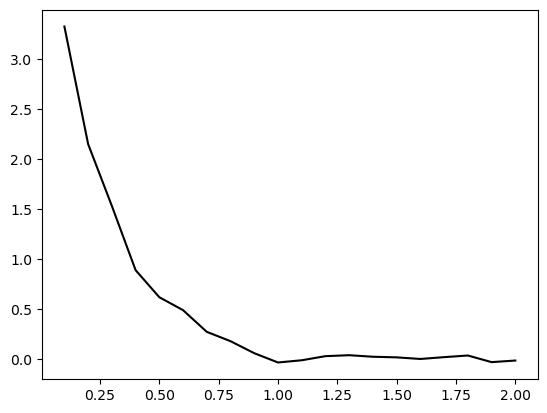

In [463]:
plt.plot(time, exps, 'k')

## Future Todos:
- write up docs and post on GitHub
- rigorously test each function a bit better
- refactor the code so the functions are more consistent with each other, the code looks cleaner
- introduce error handling
- look for opportunities to optimize: current approack is brute forceu
- make things more user-friendly
- separate hamiltonian class
- implement mixed state